## Problem 3 - Event based approach

In [11]:
import numpy as np
import pandas as pd

# Define event types to avoid using magic strings
Q1_ARR = "Q1_ARR"
Q1_DONE = "Q1_DONE"
Q2_DONE = "Q2_DONE"

class EventQueue:
    def __init__(self):
        self.queue = {}
        self.passed_events = []
        self.current_time = 0
    
    def plan_q1_arr(self):
        self.queue[self.current_time + 3600 * np.random.exponential(1/100)] = Q1_ARR
    
    def plan_q1_done(self):
        self.queue[self.current_time + 3600 * np.random.exponential(1/200)] = Q1_DONE
    
    def plan_q2_done(self):
        self.queue[self.current_time + 3600 * np.random.exponential(1/110)] = Q2_DONE

    def get_next_event(self):
        # Find next event scheduled in the future
        event_times = sorted(self.queue.keys())
        # Remove events that are in the past or now
        event_times = [t for t in event_times if t > self.current_time]

        # Get the next event
        next_event_time = event_times[0]

        # Get the event type
        event_type = self.queue[next_event_time]

        # Add the event to the passed events
        self.passed_events.append((next_event_time, event_type))
        # Remove the event from the queue
        del self.queue[next_event_time]
        # Update the current time
        self.current_time = next_event_time
        return next_event_time, event_type



def simulate(N=10000):
    queue = EventQueue()
    # Initialize the first event
    queue.plan_q1_arr()
    cars_left = 0

    # Initialize the number of cars in each queue
    q1 = 0
    q2 = 0

    while cars_left < N:
        time, event_type = queue.get_next_event()

        if event_type == Q1_ARR:
            q1 += 1
            if q1 == 1 and q2 < 10:
                queue.plan_q1_done()
            
            queue.plan_q1_arr()

        elif event_type == Q1_DONE:
            q1 -= 1
            q2 += 1

            if q1 != 0 and q2 < 10:
                queue.plan_q1_done()
            
            if q2 == 1:
                queue.plan_q2_done()
        
        elif event_type == Q2_DONE:
            cars_left += 1
            q2 -= 1
            if q2 == 9 and q1 > 0:
                # q2 was just full, but isn't anymore
                # and someone is waiting in q1
                queue.plan_q1_done()
            if q2 != 0:
                queue.plan_q2_done()
    
    return queue

def simulate_df(*args):
    event_queue = simulate(*args)

    df_data = []

    arrived, q1, q2, q1_done, q2_done = 0, 0, 0, 0, 0

    for event_time, event_type in event_queue.passed_events:
        if event_type == Q1_ARR:
            q1 += 1
            arrived += 1
        elif event_type == Q1_DONE:
            q1 -= 1
            q1_done += 1
            q2 += 1
        elif event_type == Q2_DONE:
            q2 -= 1
            q2_done += 1
        
        df_data.append((event_time/60/60, event_type, q1, q2, arrived, q1_done, q2_done))

    return pd.DataFrame(df_data, columns=["time", "event_type", "q1", "q2", "arrived", "q1_done", "q2_done"])

df = simulate_df(10000)
df

,time,event_type,q1,q2,arrived,q1_done,q2_done
0,0.005376,Q1_ARR,1,0,1,0,0
1,0.007144,Q1_DONE,0,1,1,1,0
2,0.013632,Q2_DONE,0,0,1,1,1
3,0.015872,Q1_ARR,1,0,2,1,1
4,0.025430,Q1_DONE,0,1,2,2,1
...,...,...,...,...,...,...,...
30003,101.280803,Q1_DONE,0,5,10003,10003,9998
30004,101.283636,Q2_DONE,0,4,10003,10003,9999
30005,101.288711,Q1_ARR,1,4,10004,10003,9999
30006,101.289462,Q1_DONE,0,5,10004,10004,9999


### Part 3.2

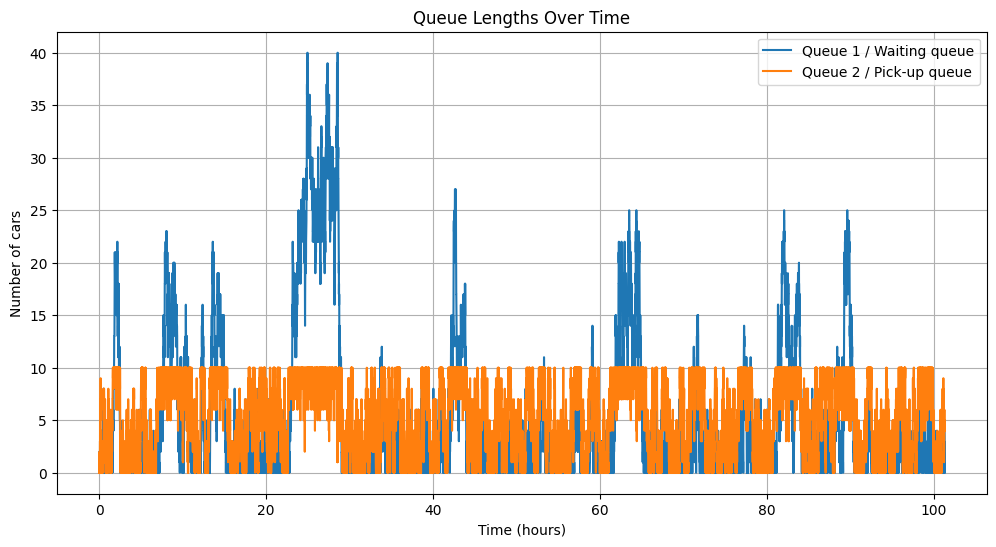

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df["time"], df["q1"], label="Queue 1 / Waiting queue")
plt.plot(df["time"], df["q2"], label="Queue 2 / Pick-up queue")
plt.xlabel("Time (hours)")
plt.ylabel("Number of cars")
plt.title("Queue Lengths Over Time")
plt.legend()
plt.grid()
plt.show()

### Part. 3.3

In [60]:

# Filter the events for Q2_DONE and arrival events and create a copy to avoid SettingWithCopyWarning
q2_done_events = df[df["event_type"] == Q2_DONE].copy()
q1_arr_events = df[df["event_type"] == Q1_ARR].copy()
q1_done_events = df[df["event_type"] == Q1_DONE].copy()

# Calcuate the three types of waiting times
waiting_time_df = pd.DataFrame()
# Find amount of cars that actually left by length of q2_done_events
Q2_DONE_amount = len(q2_done_events)
# Shorten the two other dataframes to the same length
q1_arr_events = q1_arr_events.iloc[:Q2_DONE_amount]
q1_done_events = q1_done_events.iloc[:Q2_DONE_amount]

waiting_time_df["Q1"] = q1_done_events["time"].values - q1_arr_events["time"].values
waiting_time_df["Q2"] = q2_done_events["time"].values - q1_done_events["time"].values
waiting_time_df["Total"] = waiting_time_df["Q1"] + waiting_time_df["Q2"]
waiting_time_df = waiting_time_df.dropna()

waiting_time_df


,Q1,Q2,Total
0,0.001769,0.006488,0.008256
1,0.009558,0.000477,0.010035
2,0.002556,0.007121,0.009677
3,0.007844,0.006392,0.014236
4,0.005927,0.003713,0.009640
...,...,...,...
9995,0.016986,0.036552,0.053538
9996,0.025573,0.023322,0.048895
9997,0.024669,0.028718,0.053387
9998,0.026321,0.019253,0.045574


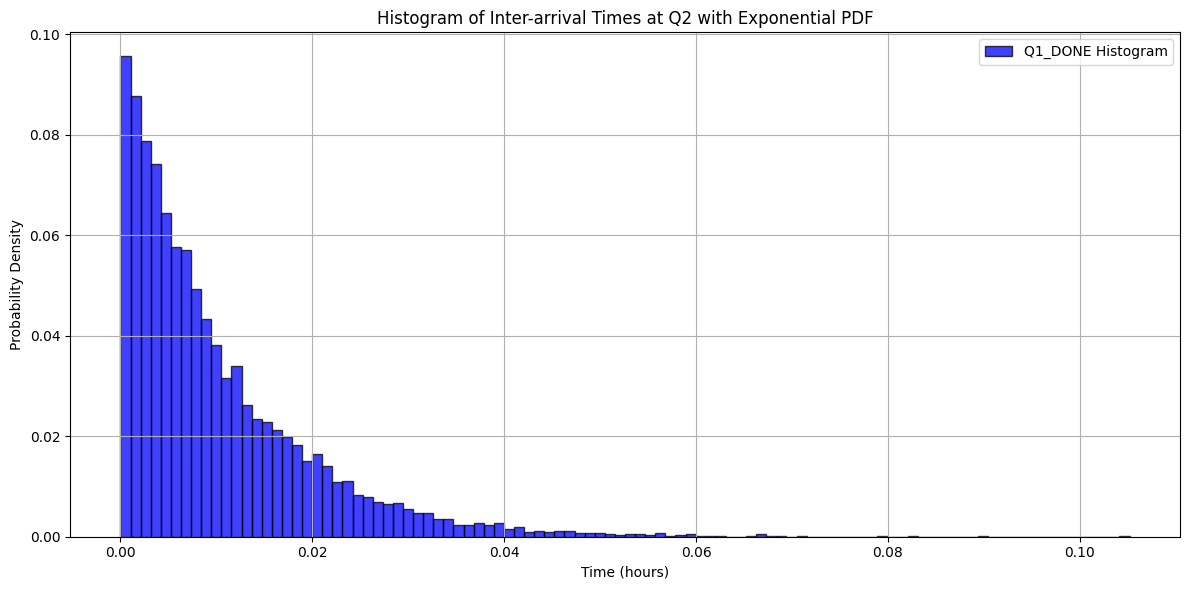

In [156]:


lambda_ = 100  # Arrival rate for Q1
mu_1 = 200  # Service rate for Q1
mu_2 = 110  # Service rate for Q2

# Plot inter-arrival at Q2, that is time between Q1_DONE events
inter_arrival_times = q1_done_events.time.diff().dropna()  # Drop NaN values from the diff
weights = np.ones_like(inter_arrival_times) / len(inter_arrival_times)  # Normalize to emulate a PDF

# Create a single plot
plt.figure(figsize=(12, 6))

# Plot the histogram
plt.hist(inter_arrival_times, bins=100, alpha=0.75, label="Q1_DONE Histogram", color="blue", weights=weights, edgecolor="black")


# Define the range of x values for exponential functions
x = np.linspace(0, waiting_time_df["Total"].max(), 1000)



# Add labels, title, legend, and grid
plt.xlabel("Time (hours)")
plt.ylabel("Probability Density")
plt.title("Histogram of Inter-arrival Times at Q2 with Exponential PDF")
plt.legend()
plt.grid()


# Show the plot
plt.tight_layout()
plt.show()


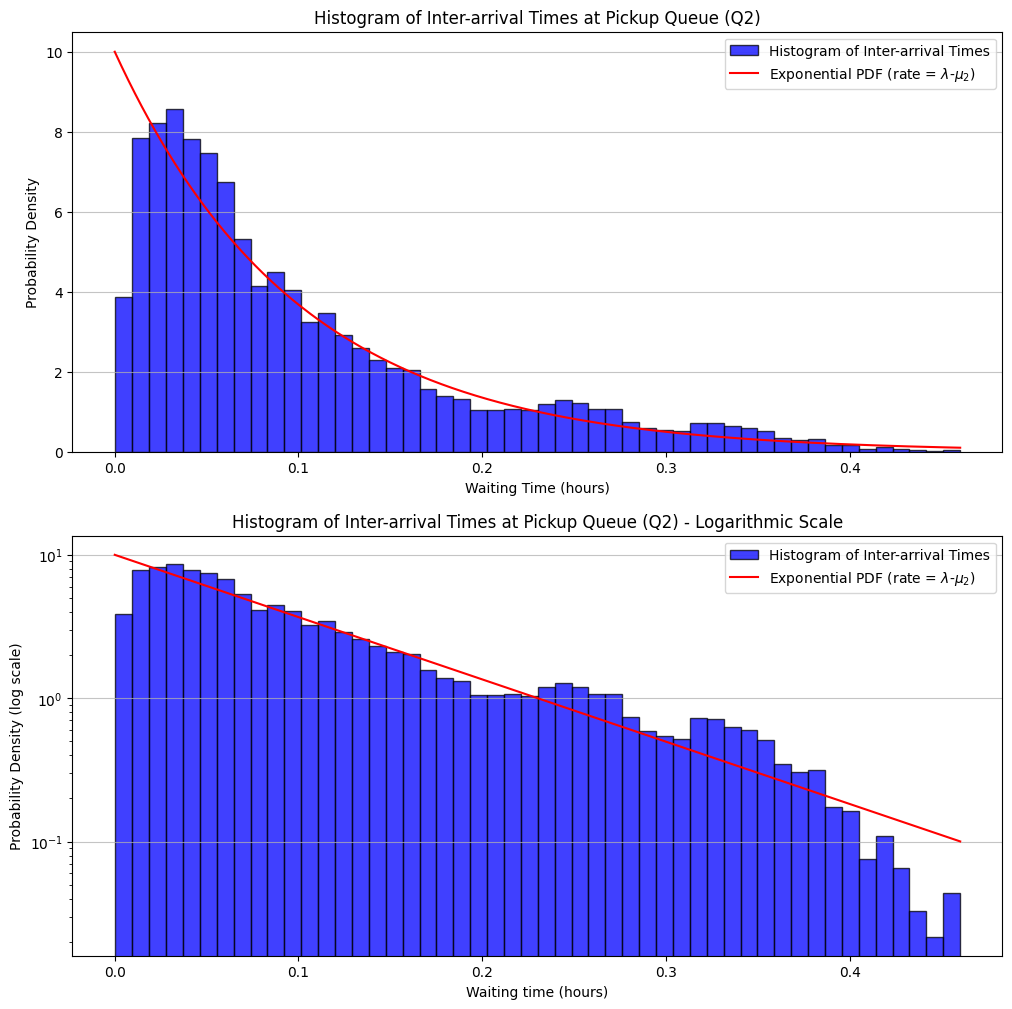

In [ ]:
from scipy.stats import poisson

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# First subplot: regular histogram
hist_data, bins, _ = axes[0].hist(
	waiting_time_df["Total"], bins=50, alpha=0.75, color='blue', edgecolor='black', density=True, label='Histogram of Inter-arrival Times'
)
axes[0].set_xlabel("Waiting Time (hours)")
axes[0].set_ylabel("Probability Density")
axes[0].set_title("Histogram of Inter-arrival Times at Pickup Queue (Q2)")
axes[0].grid(axis='y', alpha=0.75)

# Second subplot: histogram with logarithmic y-axis
axes[1].hist(
	waiting_time_df["Total"], bins=50, alpha=0.75, color='blue', edgecolor='black', density=True, label='Histogram of Inter-arrival Times', log=True
)
axes[1].set_yscale('log')
axes[1].set_xlabel("Waiting time (hours)")
axes[1].set_ylabel("Probability Density (log scale)")
axes[1].set_title("Histogram of Inter-arrival Times at Pickup Queue (Q2) - Logarithmic Scale")
axes[1].grid(axis='y', alpha=0.75)

# Define the range of x values for exponential functions
x = np.linspace(0, waiting_time_df["Total"].max(), 1000)

y = (mu_2-lambda_) * np.exp(-(mu_2-lambda_) * x)  # Exponential PDF
y = np.where(y >= 0.1, y, np.nan)  # Mask values below 0.1
axes[0].plot(x, y, label=f"Exponential PDF (rate = $\\lambda$-$\mu_2$)", color='red')
axes[1].plot(x, y, label=f"Exponential PDF (rate = $\\lambda$-$\mu_2$)", color='red')

# Update legends for both subplots
axes[0].legend()
axes[1].legend()

# Display the updated plots
plt.show()

### Part 3.4

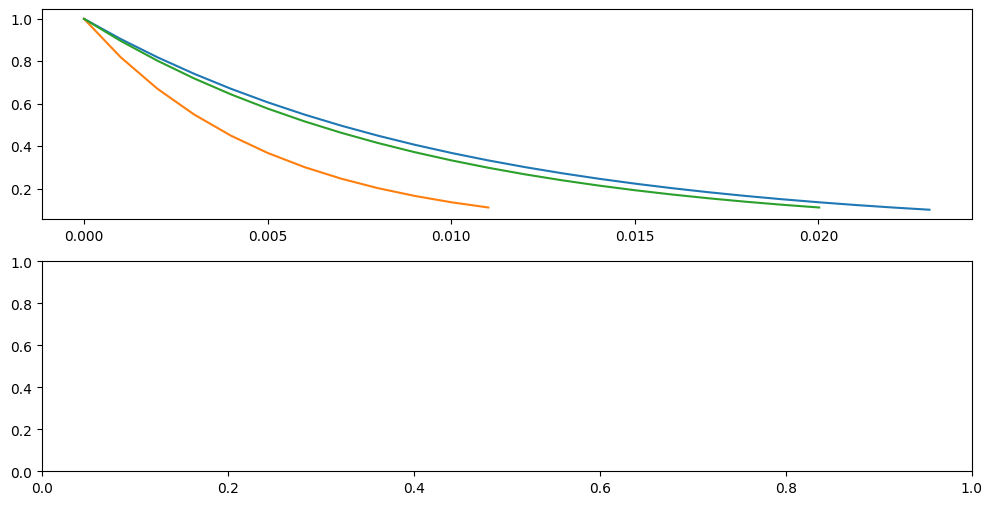

In [61]:


# Define the rates
rates = {"lambda_": lambda_, "mu_1": mu_1, "mu_2": mu_2}

# Create a figure with a single subplot
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# First plot: Exponential decay functions
for label, rate in rates.items():
    x = np.linspace(0, 1, 1000)  # Define the x range
    y = np.exp(-rate * x)  # Exponential decay
    y = np.where(y >= 0.1, y, np.nan)  # Mask values below 0.1
    axes[0].plot(x, y, label=f"Exponential decay for {label} (rate={rate})")


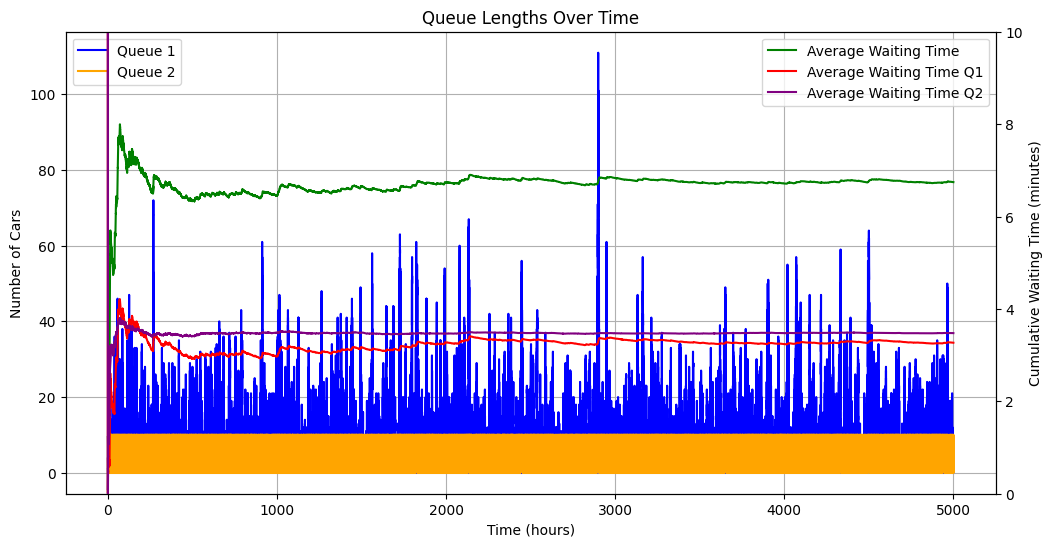

In [ ]:
df_500k = simulate_df(500000)
# Calculate the total time spent in the system for each car
df_500k["time_since_last_event"] = df_500k["time"].diff().fillna(0)

df_500k["inter_waiting_time_q1"] = df_500k["time_since_last_event"] * df_500k["q1"].shift(1).fillna(0)
df_500k["inter_waiting_time_q2"] = df_500k["time_since_last_event"] * df_500k["q2"].shift(1).fillna(0)
df_500k["inter_waiting_time"] = df_500k["inter_waiting_time_q1"] + df_500k["inter_waiting_time_q2"]

df_500k["cumulative_waiting_time_q1"] = df_500k["inter_waiting_time_q1"].cumsum()
df_500k["cumulative_waiting_time_q2"] = df_500k["inter_waiting_time_q2"].cumsum()
df_500k["cumulative_waiting_time"] = df_500k["inter_waiting_time"].cumsum()
# Calculate the average waiting time at each point in time
df_500k["average_waiting_time"] = df_500k["cumulative_waiting_time"] / (df_500k["arrived"].shift(1).fillna(0) + 1e-10)
df_500k["average_waiting_time_q1"] = df_500k["cumulative_waiting_time_q1"] / (df_500k["q1_done"].shift(1).fillna(0) + 1e-10)
df_500k["average_waiting_time_q2"] = df_500k["cumulative_waiting_time_q2"] / (df_500k["q2_done"].shift(1).fillna(0) + 1e-10)

# Plot the cumulative waiting time on top of the queue lengths using separate y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.plot(df_500k["time"], df_500k["q1"], label="Queue 1", color='blue')
ax1.plot(df_500k["time"], df_500k["q2"], label="Queue 2", color='orange')
ax1.set_xlabel("Time (hours)")
ax1.set_ylabel("Number of Cars")
ax1.set_title("Queue Lengths Over Time")
ax1.legend(loc='upper left')
ax2.plot(df_500k["time"], df_500k["average_waiting_time"] * 60, label="Average Waiting Time", color='green')
ax2.plot(df_500k["time"], df_500k["average_waiting_time_q1"] * 60, label="Average Waiting Time Q1", color='red')
ax2.plot(df_500k["time"], df_500k["average_waiting_time_q2"] * 60, label="Average Waiting Time Q2", color='purple')

# Limit the average queue time axis to max 10 minutes
ax2.set_ylim(0, 10)

ax2.set_ylabel("Cumulative Waiting Time (minutes)")
ax2.legend(loc='upper right')
ax1.grid()
plt.show()

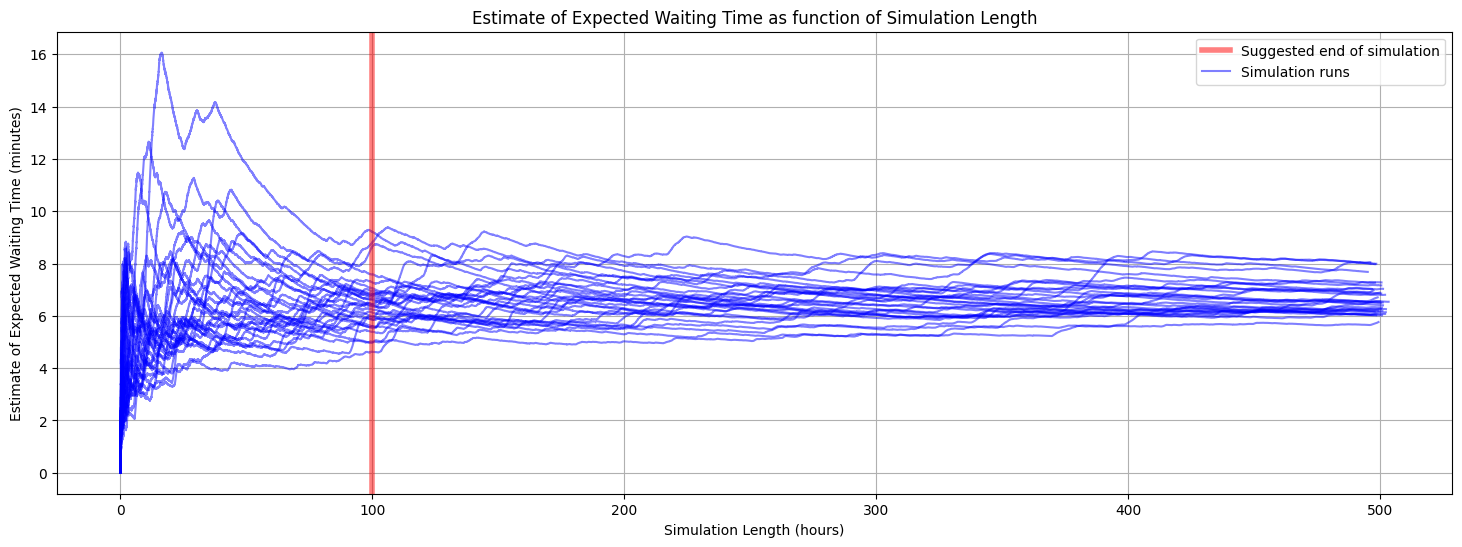

In [9]:
plt.figure(figsize=(18, 6))

# Do 5 simulation and plot the average waiting time for each simulation
for i in range(30):
    df = simulate_df(10000 * 5)
    df["time_since_last_event"] = df["time"].diff().fillna(0)
    df["inter_waiting_time"] = df["time_since_last_event"] * (df["q1"].shift(1).fillna(0) + df["q2"].shift(1).fillna(0))
    df["cumulative_waiting_time"] = df["inter_waiting_time"].cumsum()
    # Calculate the average waiting time at each point in time
    df["average_waiting_time"] = df["cumulative_waiting_time"] / (df["arrived"].shift(1).fillna(0) + 1e-10)

    plt.plot(df["time"], df["average_waiting_time"] * 60, color='blue', alpha=0.5)


# Draw vertical line at 100 hours (suggested end of simulation)
plt.axvline(x=100, color='red', label='Suggested end of simulation', linewidth=4, alpha=0.5)
# Add a legend entry to show that blue lines represent simulation runs
plt.plot([], [], color='blue', label='Simulation runs', alpha=0.5)

plt.xlabel("Simulation Length (hours)")
plt.ylabel("Estimate of Expected Waiting Time (minutes)")
plt.title("Estimate of Expected Waiting Time as function of Simulation Length")
plt.legend()
plt.grid()
plt.show()